# Cost Projection Model From 2022 Medicare Current Beneficiary Survey - Cost Supplement

Updated 2025-07-08

Created 2025-07-07

Holland Brown [holland-reece](https://github.com/holland-reece)

### About the Dataset: 2022 MCBS - Cost Supplement
Source: https://data.cms.gov/medicare-current-beneficiary-survey-mcbs/medicare-current-beneficiary-survey-cost-supplement

- Dataset comes from Centers for Medicare & Medicaid Services (CMS)
- Contains:
    - basic demographic info on Medicare beneficiaries
    - expenditures and payment sources for co-payments, deductibles and non-covered services
    - BRR (Balanced Repeated Replication) weights --> characterize uncertainty in the survey df
- Note: BBR weights allow for variance estimation (and calculation of std error, CI) without accessing confidential info

### About the Model Type: Gradient Boosting Decision Tree
- Gradient-boosted decision trees work well with multi-modal datasets that include some categorical variables
- There are lots of covariates in EHR data --> GB trees are good at capturing nonlinearities and interactions
- Robust to datasets with missing or incomplete data, like EHR
- Can use SHAP metrics (which are model‐agnostic) to show which features were most important to each prediction


In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm # package to display run progress

from sklearn.linear_model import Ridge
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# import lightgbm as lgb # LightGBM
from sklearn.ensemble import GradientBoostingRegressor # model type
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score # metrics for evaluating the model
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_validate, train_test_split # pkgs to prep data for both model implementations
from sklearn.pipeline import Pipeline # pkg to help implement K-fold cross val
import shap # Shapley additive explanations


/opt/anaconda3/envs/medicare-model-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set paths
wkdir = '/Users/hollandbrown/Desktop/cost-projection' # working directory
outdir = f'{wkdir}/results' # output directory
datadir = f'{wkdir}/MCBS-Cost-Supplement-data/CSPUF2022_Data' # data directory (contains raw CSV and text file with encodings)
raw_csv = f'{datadir}/cspuf2022.csv' # full path to raw data CSV
# raw_xpt = f'{datadir}/cspuf2022.xpt' # full path to raw data XPT

# Read CSV as pandas df and view first 10 rows
data = pd.read_csv(raw_csv)#, index_col=0) # read CSV into pandas df
# data = pd.read_sas(raw_xpt, format="xport", encoding="latin-1") # read XPT into df
# data.head(10) # display first 10 rows of data

/var/folders/5y/qyv_j5ps5mj1t03g24ml4xwm0000gn/T/ipykernel_7777/3875585184.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(raw_csv)#, index_col=0) # read CSV into pandas df


In [3]:
# Explore dataset

df = data.copy() # Make copy so I don't edit raw dataset

print(df.shape) # num rows and columns
print(df.columns.tolist()) # list of column names

# Return number of NaNs in a specific column
# print(f'LocationId: {df['LocationId'].isna().sum()}')
# print(f'GeoLocation: {df['GeoLocation'].isna().sum()}')

# Return number of unique elements in a column
print(f"Unique Elems in SURVEYYR: {df['SURVEYYR'].nunique()}") # survey year
print(f"Unique Elems in CSP_AGE: {df['CSP_AGE'].nunique()}") # patient age
print(f"Unique Elems in CSP_NCHRNCND: {df['CSP_NCHRNCND'].nunique()}") # number of chronic conditions

# Print first few elements in a column
print(df['PAMTTOT'].head(10)) # total payments from all sources 2022



(6621, 134)
['PUF_ID', 'SURVEYYR', 'VERSION', 'CSP_AGE', 'CSP_SEX', 'CSP_RACE', 'CSP_INCOME', 'CSP_NCHRNCND', 'PAMTDU', 'PAMTVU', 'PAMTHU', 'PAMTHH', 'PAMTIP', 'PAMTMP', 'PAMTOP', 'PAMTPM', 'DUAEVNTS', 'VUAEVNTS', 'HUAEVNTS', 'HHAEVNTS', 'IPAEVNTS', 'MPAEVNTS', 'OPAEVNTS', 'PMAEVNTS', 'PAMTTOT', 'PAMTCARE', 'PAMTCAID', 'PAMTMADV', 'PAMTALPR', 'PAMTOOP', 'PAMTDISC', 'PAMTOTH', 'PEVENTS', 'CSPUFWGT', 'CSPUF001', 'CSPUF002', 'CSPUF003', 'CSPUF004', 'CSPUF005', 'CSPUF006', 'CSPUF007', 'CSPUF008', 'CSPUF009', 'CSPUF010', 'CSPUF011', 'CSPUF012', 'CSPUF013', 'CSPUF014', 'CSPUF015', 'CSPUF016', 'CSPUF017', 'CSPUF018', 'CSPUF019', 'CSPUF020', 'CSPUF021', 'CSPUF022', 'CSPUF023', 'CSPUF024', 'CSPUF025', 'CSPUF026', 'CSPUF027', 'CSPUF028', 'CSPUF029', 'CSPUF030', 'CSPUF031', 'CSPUF032', 'CSPUF033', 'CSPUF034', 'CSPUF035', 'CSPUF036', 'CSPUF037', 'CSPUF038', 'CSPUF039', 'CSPUF040', 'CSPUF041', 'CSPUF042', 'CSPUF043', 'CSPUF044', 'CSPUF045', 'CSPUF046', 'CSPUF047', 'CSPUF048', 'CSPUF049', 'CSPUF050'

In [4]:
# Clean data: Remove non-float values from feature columns

colname = 'CSP_NCHRNCND'
# colname = 'CSP_AGE'
# colname = 'CSP_SEX'
# colname = 'CSP_RACE'

# Find and print non-float elements in col (this block does not edit the df)
numeric_col = pd.to_numeric(df[colname], errors='coerce') # Convert col to numeric; coerce non-numeric to NaN
non_float_mask = numeric_col.isna() # Find rows where the conversion resulted in NaN
non_float_values = df.loc[non_float_mask, colname] # Select the original non-float values from col
print(non_float_values)

# Remove rows where column is NaN (this block edits the df)
df[colname] = numeric_col # edits column in place
df = df.dropna(subset=colname)
print(f'New dimensions: {df.shape}')

# print(numeric_col.shape)


6424    R
Name: CSP_NCHRNCND, dtype: object
New dimensions: (6620, 134)


### Regularized linear regressor (Ridge)
- Use Ridge first to get a sense of feature importances and error scale (MAE/RMSE) before LightGBM

In [ ]:
# Ridge linreg

RX = X.copy()
Ry = y.copy()

# create list of possible lambda values
lambda_val = list(np.linspace(0.01, 10, 100))

# use K-fold cross validation to choose lambda
Rloss_mat = np.zeros((len(lambda_val)))
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1234)

for i in range(len(lambda_val)):
    loss = np.zeros((n_splits))
    
    j = 0
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = RX[train_idx], RX[test_idx]
        y_train, y_test = Ry[train_idx], Ry[test_idx]
    
        R = Ridge(lambda_val[i])
        R.fit(X_train, y_train)
        y_pred = R.predict(X_test)
        loss[j] += mean_squared_error(y_test, y_pred)/y_pred.size     # normalize MSE to num of pts
        
        j += 1

    Rloss_mat[i] = loss.mean()               # avg loss values for each lambda value
        
Rbest_idx = np.argmin(Rloss_mat, axis=0)     # find lowest average loss
lambda_ridge = lambda[Rbest_idx]                       # best lambda val is the one with lowest avg loss  
ridge_mse = Rloss_mat[np.argmin(Rloss_mat)]

# evaluate model performance using l2 norm; print beta values
print(f'Ridge loss: {ridge_mse :.4f}')    # normalize MSE to num of pts

### SKLearn Gradient Boosting Decision Tree
- Tuning Parameters
    - n_estimators: number of trees
    - learning_rate: smaller --> more trees needed
    - max_depth: controls complexity, depth of trees

#### (1) Simple GB Decision Tree Implementation

In [ ]:
# Prep data for modeling: Split into test/train, shuffle, scale, etc.

# Define target and features manually
TARGET = "PAMTTOT"   # what I want to predict using features (PAMTTOT == total payments from all sources in 2022)
FEATURES = ["CSP_AGE", "CSP_SEX", "CSP_RACE", "CSP_NCHRNCND"]  # list any features I want to include

# Extract feats and target from dataframe
X_simple = df[FEATURES]
y_simple = df[TARGET]

# 90/10 train/test split --> now I have 4 subsets of data: X/y train and X/y test
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, y_simple, test_size=0.10, random_state=42, shuffle=True
)

# Scale features to mean 0 and unit variance
# X = StandardScaler().fit_transform(x)

# Using SKLearn built-in GB regressor
model_simple = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_simple.fit(X_train_simple, y_train_simple)


GradientBoostingRegressor(n_estimators=200, random_state=42)

#### Evaluate Simple GB Decision Tree Performance

MAE: 15375.09
RMSE: 30875.76
R²: 0.003


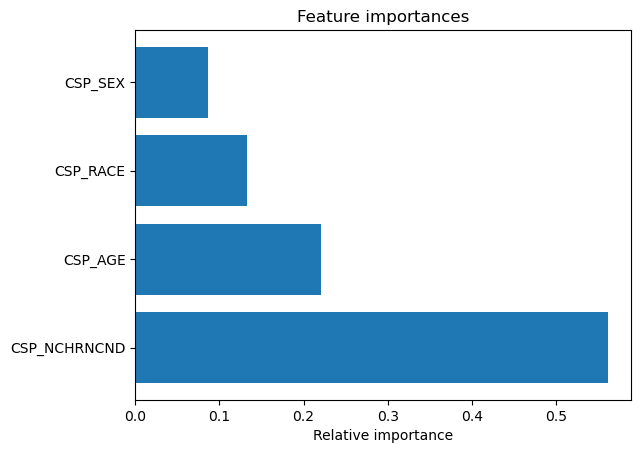

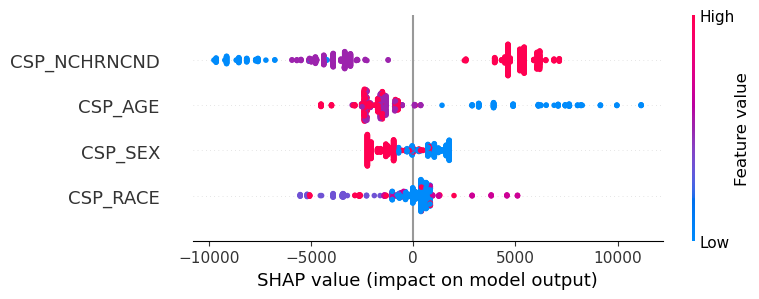

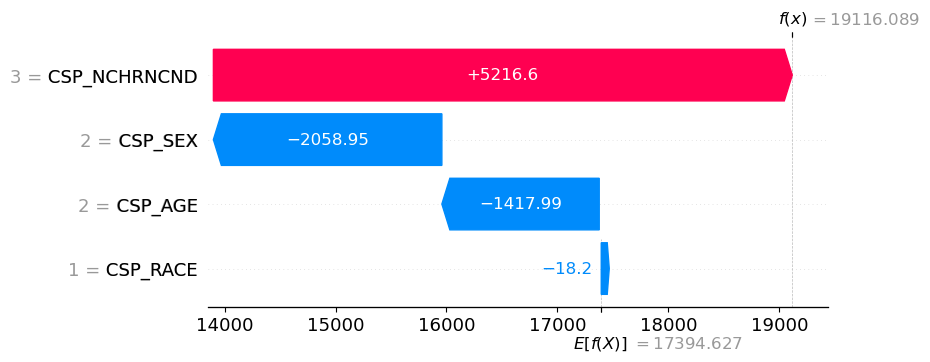

In [ ]:
# (1) Evaluate Model Performance
preds_simple = model_simple.predict(X_test_simple)

mae  = mean_absolute_error(y_test_simple, preds_simple)
rmse = root_mean_squared_error(y_test_simple, preds_simple)
r2   = r2_score(y_test_simple, preds_simple)

print(f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}")


# (2) Examine feature importances
importances = model_simple.feature_importances_
idx_sorted = importances.argsort()[::-1]
feat_sorted = [FEATURES[i] for i in idx_sorted]

plt.barh(feat_sorted, importances[idx_sorted])
plt.xlabel("Relative importance")
plt.title("Feature importances")
plt.show()


# (3) Use SHAP to quantify model performance
explainer = shap.Explainer(model_simple, X_train_simple)
shap_values = explainer(X_test_simple)

# SHAP summary plot (global view)
shap.summary_plot(shap_values, X_test_simple)

# SHAP plot for a single prediction (local view)
patient_idx = 0
shap.plots.waterfall(shap_values[patient_idx]) # waterfall plot breaks down why model predicted a certain cost


#### (2) GB Decision Tree with K-Fold Cross Val and Feat Selection

In [ ]:
# Second implementation of same kind of model, this time with k-fold cross val

# Define target and features manually
TARGET = "PAMTTOT"   # what I want to predict using features (PAMTTOT == total payments from all sources in 2022)
FEATURES = ["CSP_AGE", "CSP_SEX", "CSP_RACE", "CSP_NCHRNCND"]  # list any features I want to include

X = df[FEATURES]
y = df[TARGET]

# K-fold cross validation with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Build pipeline: first select features, then fit the regressor
selector = SelectFromModel(
    estimator=GradientBoostingRegressor(random_state=42),
    threshold="median" # keep features more important than the median
)

model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

pipe = Pipeline([
    ("feature_selection", selector),
    ("regressor", model)
])

# Cross-validate
scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2":  make_scorer(r2_score)
}

cv_results = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("CV MAE: {:.2f} ± {:.2f}".format(
    -cv_results["test_MAE"].mean(),
     cv_results["test_MAE"].std()
))
print("CV R²:  {:.3f} ± {:.3f}".format(
     cv_results["test_R2"].mean(),
     cv_results["test_R2"].std()
))


CV MAE: 15367.72 ± 730.90
CV R²:  0.029 ± 0.012
